# DB[RC/S3]

Density-Based Residue Clustering by Dissimilarity Between Sequence SubSets

In [76]:
###====================================================================================================
### Dependencies
###====================================================================================================
# !pip install Bio
# !pip install networkx
# !pip install sklearn
# !pip install pyclustering
# !pip install pandas
# !pip install seaborn
# !pip install scipy

In [77]:
###====================================================================================================
### Libraries
###====================================================================================================
try:
	# import argparse
	from Bio import SeqIO
	from Bio import Phylo
	import numpy as np
	import networkx as nx
	from sklearn import manifold
	from sklearn.metrics import euclidean_distances
	from sklearn.decomposition import PCA
	from pyclustering.cluster.optics import optics
	from pyclustering.cluster.optics import ordering_analyser 
	import matplotlib.pyplot as plt
	import pandas as pd
	import seaborn as sns; sns.set(color_codes=True)
	from scipy.cluster.hierarchy import dendrogram, linkage, to_tree
	from Bio.SeqUtils import seq3
except:
	raise ImportError('Need the following packages installed: argparse, numpy, scipy, matplotlib, networkx, Bio, pyclustering, sklearn, pandas and seaborn.')

In [78]:
###====================================================================================================
### Parameters
###====================================================================================================
# parser = argparse.ArgumentParser(description = "Density Based Residue Clustering by Dissimilarity Between Sequence SubSets (DBRC/DBS3).")
# parser.add_argument("file", help = "Path to multiple sequence alignment file in FASTA format.", type = str)
# parser.add_argument("-o", "--out", help = "Label to be used for naming output files (default: stdout)", type = str, default = None, required = False)
# parser.add_argument("-f", "--min_freq", help = "Threshold for minimum residue frequency (default: 0.0).", type = float, default = 0., required = False)
# parser.add_argument("-x", "--plus_aa", help = "True for expanding alphabet (default: False).", type = bool, default = False, required = False)
# parser.add_argument("-d", "--max_dist", help = "Maximum distance to reach points (default: 1.0).", type = float, default = 1., required = False)
# parser.add_argument("-s", "--min_size", help = "Minimum cluster size (default: 3).", type = int, default = 3, required = False)
# parser.add_argument("-n", "--n_clusters", help = "Expected amount of clusters (default: None).", type = int, default = None, required = False)
# args = parser.parse_args()	# returns data from the options specified (echo)

class args(object):
    def __init__(self) -> None:
        self.__getattribute__
args.file = 'sample.fasta'
args.plus_aa = True
args.min_freq = .1
args.max_dist = 1.
args.min_size = 3
args.out = None

if args.out == None:
	args.out = 'output/'+args.file.split('.')[0]

In [79]:

###====================================================================================================
### Classes
###====================================================================================================
class MSA(object):
	"""A class representing a Multiple Sequence Alignment"""
	def __init__(self, MSA_file):
		super(MSA, self).__init__()
		self.alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
		self.sthereochemistry = {
			'Aliphatic':['G','A','V','L','I'],
			'Amide':['N','Q'],
			'Aromatic':['F','Y','W'],
			'Basic':['H','K','R'],
			'Big':['M','I','L','K','R'],
			'Hydrophilic':['R','K','N','Q','P','D'],
			'Median':['E','V','Q','H'],
			'Negatively charged':['D','E'],
			'Non-polar':['F','G','V','L','A','I','P','M','W'],
			'Polar':['Y','S','N','T','Q','C'],
			'Positively charged':['K','R'],
			'Similar (Asn or Asp)':['N','D'],
			'Similar (Gln or Glu)':['Q','E'],
			'Small':['C','D','P','N','T'],
			'Tiny':['G','A','S'],
			'Very hydrophobic':['L','I','F','W','V','M'],
			'With hydroxyl':['S','T','Y'],
			'With sulfur':['C','M']
		}
		self.data = self.parse(MSA_file)
		self.headers, self.sequences = self.read()
		self.size, self.length = np.array(self.sequences).shape
		self.weights = self.Henikoff()
		self.sequence_indices = {x:i for i,x in enumerate(self.headers)}
		self.colection = self.colect()
	def parse(self, MSA_file):
		try:
			return list(SeqIO.parse(MSA_file, "fasta"))
		except FileNotFoundError:
			raise SystemExit("No such file or directory: '%s'" % args.file)
	def read(self):
		headers, sequences = [], []
		for seq in self.data:
			headers.append(seq.id)
			sequences.append(list(seq.seq))
		return (headers, np.array(sequences))
	def Henikoff(self):
		weights = []
		for i in range(self.size):
			row = []
			for j in range(self.length):
				x = self.sequences[i][j]
				k = float(len(set(self.sequences[:, j])))
				n = 0.
				for y in self.sequences[:, j]:
					if y == x:
						n += 1.
				row.append(1. / (k * n)) 
			weights.append(sum(row) / float(self.length))
		return weights
	def colect(self):
		colection = {}
		for l in range(self.length):
			colection[l]=[]
			for a in self.alphabet:
				if a in self.sequences[:, l]:
					sequence_indices = []
					for n in range(self.size):
						if self.sequences[n][l]==a:
							sequence_indices.append(n)
					colection[l].append(Residue(self, a, l, sequence_indices))
		if args.plus_aa:
			for l in range(self.length): # For each column of the alignment, it looks for all possible subsets of similar amino acids.
				temp = {}
				for k, v in list(self.sthereochemistry.items()):
					if len(set(self.sequences[:, l]) & set(v)) > 0:
						temp[k] = ([],[])
				for n in range(self.size):
					for k in list(temp.keys()):
						if self.sequences[n][l] in self.sthereochemistry[k]:
							if self.sequences[n][l] not in temp[k][0]:
								temp[k][0].append(self.sequences[n][l])
							temp[k][1].append(n)
				for k, (x, y) in list(temp.items()):
					temp[k] = (tuple(x), tuple(y))
				aux={x: [] for x in set(temp.values())}
				for k, v in list(temp.items()):
					aux[v].append(k)
				for (aa, idx), ftr in list(aux.items()):
					if len(aa) > 1:
						for i in range(len(ftr)):
							if 'Similar' in ftr[i]:
								ftr[i] = 'Similar'
						label = ', '.join(ftr)
						colection[l].append(Residue(self, list(aa), l, list(idx), ftr))
		return colection
###====================================================================================================
class Subset(object):
	"""A class for subsets of sequences from the MSA"""
	def __init__(self, MSA_object, sequence_indices, label = None):
		super(Subset, self).__init__()
		self.msa = MSA_object
		self.sequence_indices = set(sequence_indices)
		self.label = label
		self.p = self.probability(self)
	def __repr__(self):
		return self.label
	class probability:
		def __init__(self, subset):
			self.subset = subset
			self.result = float(sum(map(lambda x: self.subset.msa.weights[x], self.subset.sequence_indices)))
		def __call__(self):
			return self.result
		def given(self, other_subset):
			return float(sum(map(lambda x: self.subset.msa.weights[x], self.subset.sequence_indices & other_subset.sequence_indices))) / other_subset.p()
###====================================================================================================
class Residue(Subset): # A special kind of Subset, inherited from it, for sets of sequences defined by having a specific residue (or sthereochemistry) at a given position.
	def __init__(self, MSA_object, amino_acid, position, sequence_indices, sthereochemistry=None, label = None):
		Subset.__init__(self, MSA_object, sequence_indices, label)
		self.sthereochemistry = sthereochemistry
		self.amino_acid = amino_acid
		self.position = position
		self.label = self.labeling()
	def labeling(self):
		if len(self.amino_acid) == 1:
			return seq3(self.amino_acid)
		else:
			if len(self.sthereochemistry) > 1:
				return '%s (%s or %s)' % (', '.join(self.sthereochemistry), ', '.join(map(seq3, self.amino_acid[:-1])), seq3(self.amino_acid[-1]))
			return '%s (%s or %s)' % (self.sthereochemistry[0], ', '.join(map(seq3, self.amino_acid[:-1])), seq3(self.amino_acid[-1]))


In [80]:
###====================================================================================================
### UTILITIES
###====================================================================================================
def getNewick(node, newick, parentdist, leaf_names):
	if node.is_leaf():
		return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
	else:
		if len(newick) > 0:
			newick = "):%.2f%s" % (parentdist - node.dist, newick)
		else:
			newick = ");"
		newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
		newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
		newick = "(%s" % (newick)
		return newick
###====================================================================================================
def getDF(X, row_indices, column_indices):
	d = {'Seq. ID': list(map(lambda x: msa.headers[x], row_indices))}
	for i in column_indices:
		d['Clust. %d'%(i+1)] = X[:, i]
	return pd.DataFrame(d)

# Main

In [81]:
msa = MSA(args.file)

In [82]:
R = []
for l in range(msa.length):
    R += msa.colection[l]

In [83]:
G = nx.Graph()
for i, a in enumerate(R[:-1]):
    if a.p() >= args.min_freq:
        for b in R[i+1:]:
            if b.p() >= args.min_freq:
                # G.add_edge(a, b, weight = 1. - float(sum(map(lambda x: msa.weights[x], a.sequence_indices&b.sequence_indices))) / float(sum(map(lambda x: msa.weights[x], a.sequence_indices|b.sequence_indices))))
                G.add_edge(a, b, weight = float(sum(map(lambda x: msa.weights[x], a.sequence_indices^b.sequence_indices))) / float(sum(map(lambda x: msa.weights[x], a.sequence_indices|b.sequence_indices))))

In [84]:
N = sorted(G.nodes(), key=lambda x: x.p(), reverse=True)

In [85]:
D = nx.to_numpy_matrix(G, nodelist=N)

In [86]:
optics_instance = optics(D, args.max_dist, args.min_size, None, 'distance_matrix')
optics_instance.process()
clusters = optics_instance.get_clusters()

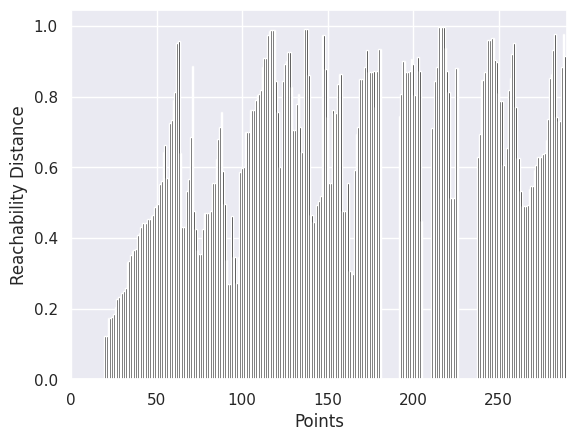

In [87]:
ordering = ordering_analyser(optics_instance.get_ordering())
ordering = ordering.cluster_ordering
fig = plt.figure()
plt.bar(range(0, len(ordering)), ordering[0:len(ordering)], width = 1., color = 'black')
plt.xlim([0, len(ordering)])
plt.xlabel('Points')
plt.ylabel('Reachability Distance')
plt.savefig('%s_reachability_plot.png' % args.out)

In [88]:
clusters = sorted(clusters, key =  lambda x: np.mean(list(map(lambda y: N[y].p(), x))), reverse=True)
i = 0
while i < len(clusters):
    positions = set(map(lambda x: N[x].position, clusters[i]))
    same_position = {k: [] for k in positions}
    for j in clusters[i]:
        same_position[N[j].position].append(j)
    temp = []
    c = Subset(msa, list(set.union(*map(lambda x: set(N[x].sequence_indices), clusters[i]))))
    for j in clusters[i]:
        if j == max(same_position[N[j].position], key = lambda x: N[x].p.given(c)):
            temp.append(j)
    if len(temp) >= args.min_size:
        clusters[i] = temp
        i += 1
    else:
        del clusters[i]

In [89]:
with open('%s_clusters.csv' % args.out, 'w') as outfile:
    for i in range(len(clusters)):
        outfile.write('Cluster %d\n' % (i+1))
        d = {'MSA\nColumn': [], 'Feature': [], 'Frequency': []}
        for j in sorted(clusters[i], key=lambda x: N[x].position):
            d['MSA\nColumn'].append(N[j].position+1)
            d['Feature'].append(N[j])
            d['Frequency'].append('%.2f' % round(N[j].p(), 2))
        df=pd.DataFrame(d)
        outfile.write(df.to_csv(index=False))
        outfile.write('\n')

In [90]:
H = []
for i in range(msa.size):
    row = []
    for j in range(len(clusters)):
        count = 0
        for k in clusters[j]:
            if i in N[k].sequence_indices:
                count += 1
        row.append(float(count) / float(len(clusters[j])))
    H.append(row)
H = np.array(H)

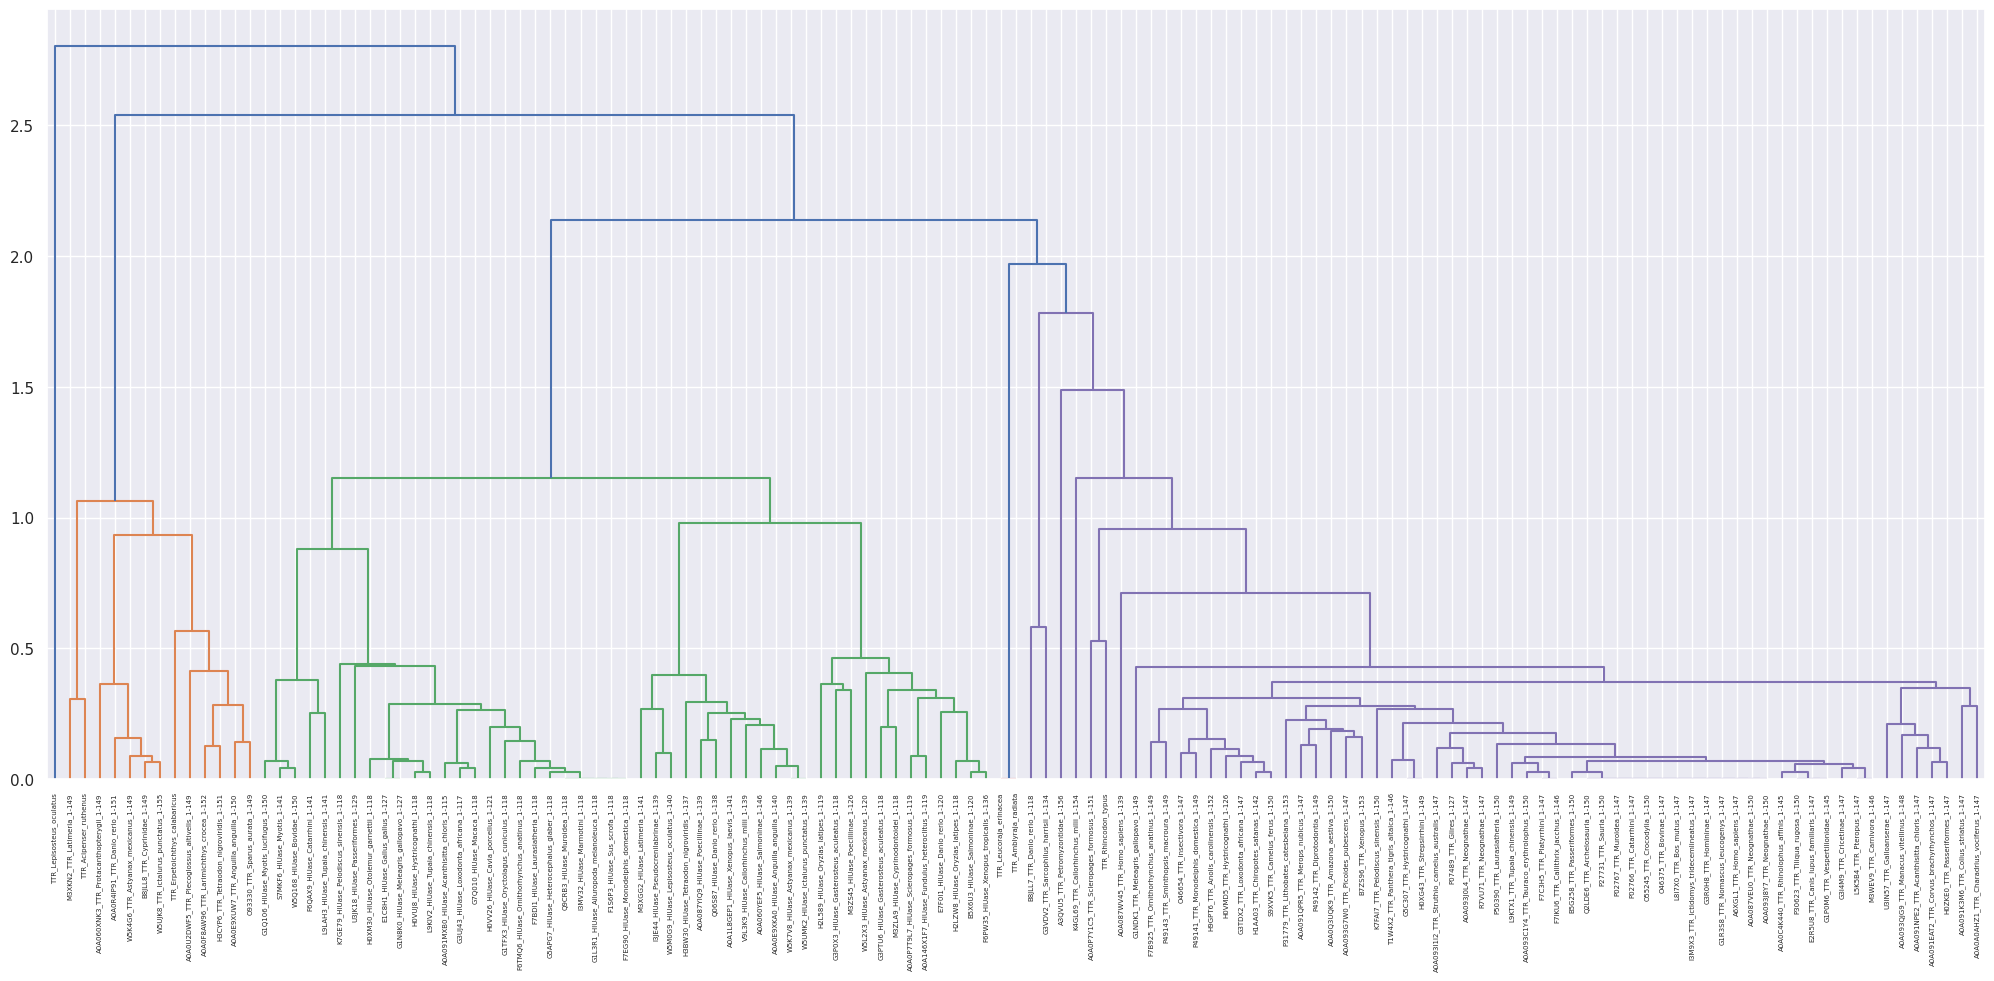

In [91]:
Z = linkage(H, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels=msa.headers)
plt.savefig('%s_dendrogram.png'%args.out)
tree = to_tree(Z, False)
with open('%s_dendrogram.nwk'%args.out, 'w') as outfile:
    outfile.write(getNewick(tree, "", tree.dist, msa.headers))

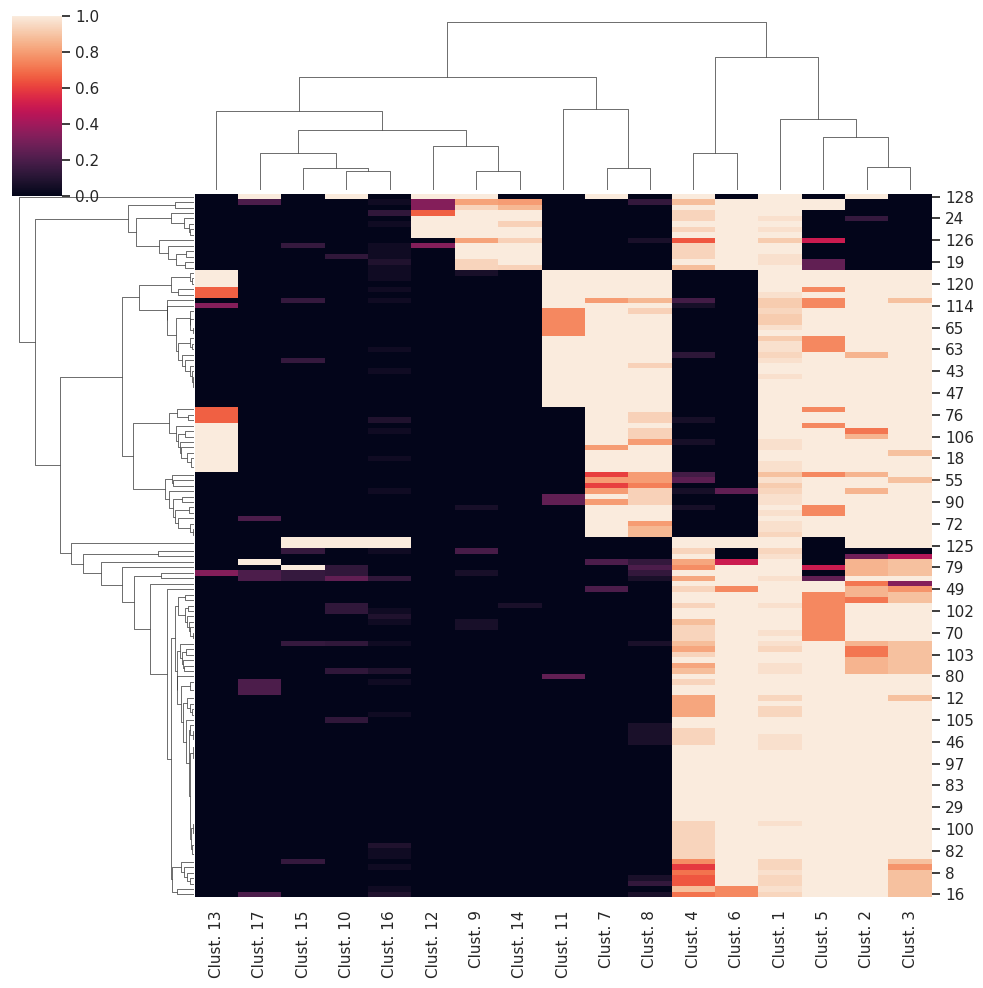

In [92]:
df=getDF(H, range(msa.size), range(len(clusters)))
seq = df.pop('Seq. ID')
try:
    g = sns.clustermap(df)
except:
    raise SystemExit('Warning: few clusters to draw a heatmap!')
row_idx=g.dendrogram_row.reordered_ind
col_idx=g.dendrogram_col.reordered_ind
H=[H[i] for i in row_idx]
H=np.array(H)
df=getDF(H, row_idx, col_idx)
df.to_csv('%s_seq_adhesion.csv' % args.out)
plt.savefig('%s_seq_adhesion.png' % args.out)

/home/lucas/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


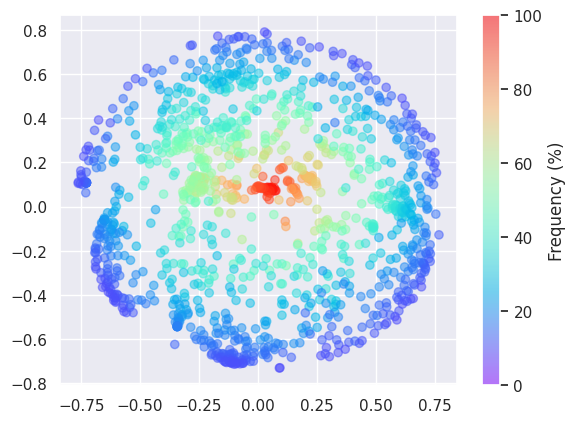

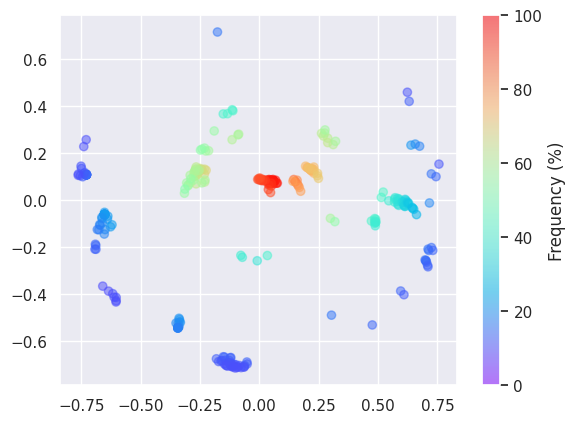

In [93]:
###====================================================================================================
### Optional viewing
###====================================================================================================
mds = manifold.MDS(n_components = 2, dissimilarity = "precomputed")
pts = mds.fit(D).embedding_
clf = PCA(n_components = 2)
pts = clf.fit_transform(pts)
###====================================================================================================
colors = np.array(list(map(lambda x: x.p(), N)))*100
fig = plt.figure()
X, Y = zip(*pts)
sc = plt.scatter(X, Y, c = colors, cmap = 'rainbow', vmin = 0., vmax = 100., alpha = .5)
cb = plt.colorbar(sc)
cb.set_label('Frequency (%s)' % '%')
plt.savefig('%s_residue_plot.png' % args.out)
###====================================================================================================
noise = optics_instance.get_noise()
points, colors = [], []
for i, (p, c) in enumerate(zip(pts, list(map(lambda x: x.p(), N)))):
    if i not in noise:
        points.append(p)
        colors.append(c)
colors = np.array(colors) * 100
fig = plt.figure()
X,Y = zip(*points)
sc = plt.scatter(X, Y, c = colors, cmap = 'rainbow', vmin = 0., vmax = 100., alpha = 0.5)
cb = plt.colorbar(sc)
cb.set_label('Frequency (%s)' % '%')
plt.savefig('%s_residue_plot_(without_noise).png' % args.out)
###====================================================================================================
### END
###====================================================================================================